# Computational Methods in Economics

## Lecture 5 - Numerical Optimization

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2017-11-24 15:48:56.354669


### Preliminaries

#### Import Modules

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import scipy.optimize

import statsmodels.api as sm

# import sys
# from importlib import reload

## This Lecture

- [Introduction](#introduction)
- [Golden Search](#golden)
- [Nelder-Mead (Simplex)](#Nelder-Mead)
- [Overview: Line Search](#overview)
- [The Newton-Raphson Method](#newton)
- [Gradient Descent](#gradient)
- [Quasi-Newton Methods: BFGS](#quasi)
- [Example: Solving the NGM](#NGM)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

## Introduction

Optimization (minimization or maximization) is at the heart of almost all economic models, which makes numerical algorithms for optimization an essential part of an economist's computational toolbox. Before talking about these algorithms in detail, we start with a short refresher on the theory behind optimization.

### Review: Unconstrained Optimization

Unconstrained optimization entails *minimizing* an (scalar) *objective function* $f: \mathbb{R}^n \rightarrow \mathbb{R}$:

\begin{equation}
    \min_{x} f(x)
\end{equation}

with
\begin{equation}
    x \in \mathbb{R}^n
\end{equation}
and $f$ being a smooth function.

Note that we frame the problem here in terms of minimization, mainly because that's how the Scipy implementations that we will see do it. *Maximizing* a function is equivalent to minimizing its negative.

Usually, we want to find a *global* minimum and hence a *global minimizer* of $f$. Formally, a global minimizer for the problem above is a point $x^*$ if $f(x^*) \le f(x)$ for all $x$ in the relevant domain. 

However, most algorithms developed for numerical optimization (and in fact all algorithms discussed in this class) aim to find a local optimum, and hence a *local minimizer*. A local minimizer is a point $x^*$ if there is a neighborhood $\mathcal{N}$ of $x^*$ such that $f(x^*) \le f(x)$ for all $x$ in $\mathcal{N}$. For a *strict* or *strong* local minimizer, the inequality is strict. If $x^*$ is the only local minimizer in $\mathcal{N}$, it is also called an *isolated* minimizer. All isolated local minimizers are strict, however strict minimizers are not always isolated.

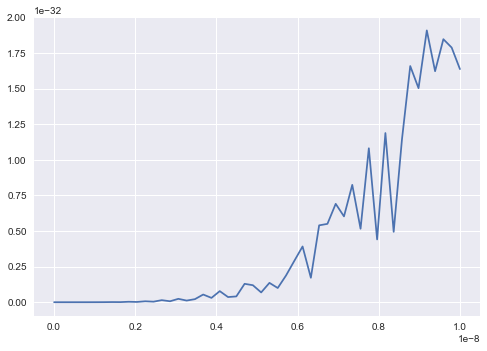

In [3]:
f = lambda x: np.cos(x**(-1)) * x**4  + 2 * x**4
x = np.linspace(1e-12, 1e-8, 50)
plt.plot(x, f(x))

Why do the methods below focus on local minimizers? The more points an algorithm has to "visit" (i.e. evaluate the function), the more computer time and/or storage it needs, which we aim to keep as small as possible. To find a global minimizer, we would need to sample points over the whole relevant domain of $f$. However, note if we know that a function is *convex*, a local minimizer is also a global minimizer 

How do we recognize a local minimum? We rely on the following necessary and sufficient conditions (that you have probably used in almost every economics class you've ever taken):
- If $x^*$ is a local minimizer of $f$ and $f$ is continuously differentiable in an open neighborhood around $x^*$, then the *gradient* $\nabla f(x^*)$ is zero. For a univariate function, $f'(x^*) = 0$.
- If $x^*$ is a local minimizer and $\nabla^2 f$ exists and is continuous in an open neighborhood around $x^*$, then $\nabla f(x^*) = 0$ and $\nabla^2 f(x^*)$ is positive semidefinite.
- Suppose that $\nabla^2 f$ is continuous in an open neighborhood around $x^*$ and that $\nabla f(x^*) = 0$ and $\nabla^2 f(x^*)$ is positive semidefinite. Then $x^*$ is a strict local minimizer of $f$.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'golden'></a>

## Golden Search

Similar to root finding, for performing numerical optimization we have both derivative-free methods as well as algorithms that either rely on analytical derivatives provided by the user or approximate the derivatives numerically. First, we look at an important method for maximizing a *univariate* function without using derivates, namely *golden (section) search*.

Conceptually, golden search is similar to bisection: we bracket the minimum $x^*$ by the interval $[a, b]$ and then sequentially reduce the length of the interval. One important difference to bisection is that we need to evaluate the function at *two* points inside the bracket, rather than one as in the case of bisection. This is illustrated by the following example:  

In [3]:
## cp. figure in class
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

The obvious question is then how to choose the *search points* $c$ and $d$ inside the bracket. Golden search prescribes the following rule:
\begin{align}
    c &= a + r (b - a) \\
    d &= b - r (b - a)
\end{align}
where
\begin{equation}
    r = \frac{3 - \sqrt{5}}{2} \approx 0.382...
\end{equation}    

This satisfies two criteria:

- The new interval always has the same length, independent whether the upper or lower bound is replaced:

\begin{equation}
       b - c = d - a = (1 - r)(b - a) 
\end{equation}   

- For every refinement after the first, one of the search points equals the search point from the previous refinement that was not used as a new bound; in other words,

    1. if $f(c) < f(d)$, the new interval is $[a, d]$; for the next refinement, $d' = c$
    2. if $f(c) > f(d)$, the new interval is $[c, b]$; for the next refinement, $c' = d$

This has the advantage that only one function evaluation is performed per iteration; e.g. in the first case, we need to evaluate $f(c')$, but we already have evaluated $f(d') = f(c)$ for the previous refinement. 

In Python, golden section search for minimizing a univariate function is implemented in **scipy.optimize.golden**. Below, we apply it on the function $f(x) = - \exp(-x) \sin(x)$:

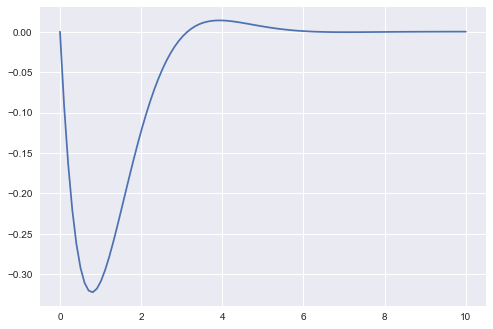

In [3]:
f = lambda x: -np.exp(-x) * np.sin(x)
x = np.linspace(0, 10, 100)
plt.plot(x, f(x))

In [4]:
scipy.optimize.golden(f, brack = (0, 2))

0.7853981651501754

We will not use golden search very often, for the simple reason that we usually optimize over functions with more than one variable. However, golden search is useful in the case of univariate functions with derivatives that are irregular or computationally costly to evaluate.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'Nelder-Mead'></a>

## Nelder-Mead (Simplex)

Compare http://www.benfrederickson.com/numerical-optimization/ for a visualization.

#### Example: "Banana" function

The *Rosenbrock function* (also called *Rosenbrock's banana function*) is often used to test the performance of optmization algorithms. It has the form:

\begin{equation}
    f(x, y) = (a - x)^2 + b (y - x^2)^2
\end{equation}

Its global minimum is at $(a, a^2)$. Below, we set $a = 1$ and $b = 100$.

In [6]:
def banana(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

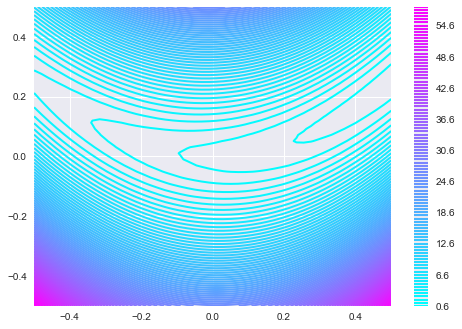

In [40]:
x = np.linspace(-0.5, 0.5, 50)
y = np.linspace(-0.5, 0.5, 50)
xx, yy = np.meshgrid(x, y)
z = banana(xx, yy)

## plot contour
fig, ax = plt.subplots()
CP = ax.contour(x, y, z, 100,  linewidths=2, cmap='cool')
fig.colorbar(CP)

In [49]:
def banana(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

In [50]:
scipy.optimize.minimize(banana, [0, 1], method = 'Nelder-Mead')

 final_simplex: (array([[ 1.00000205,  1.00000565],
       [ 0.99996743,  0.99993257],
       [ 0.99996276,  0.99992823]]), array([  2.42887199e-10,   1.58293615e-09,   2.11970761e-09]))
           fun: 2.4288719914788363e-10
       message: 'Optimization terminated successfully.'
          nfev: 191
           nit: 101
        status: 0
       success: True
             x: array([ 1.00000205,  1.00000565])

Similar to golden search in the univariate case, use the Nelder-Mead algorithm only in cases where a single optimization is performed and evaluating the function and its derivatives is costly. Nelder-Mead is slow and unreliable, in particular for problems with more than two dimensions. In those cases, we are better off with using a variant of *line search*.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'overview'></a>

## Overview: Line Search

*Line search methods* are one of the two fundamental approaches to (unconstrained) optimization (*trust region* being the other), and the one which we focus on in this course. Line search is an iterative procedure, generating a sequence of iterates $\{ x^{(k)} \}$ that are aimed to converge towards the minimum $x^*$. When moving from one iterate to the next, two variables are essential: the *search direction*, denoted by $p^{(k)}$, i.e. the direction in which to move from $x^{(k)}$, and the *distance* $\alpha^{(k)}$, i.e. the length of the step from $x^{(k)}$ to $x^{(k+1)}$. On a general level, line search algorithms take the direction $p^{(k)}$ as given and then solve the following problem:

\begin{equation}
    \min_{\alpha > 0} f(x^{(k)} + \alpha p^{(k)})
\end{equation}

and then set 

\begin{equation}
    x^{(k+1)} = x^{(k)} + s^{(k)} = x^{(k)} + \alpha p^{(k)}
\end{equation}

Different variants of line search methods differ in their choice of the search direction $p^{(k)}$ (and some also fix $\alpha$), as we will see below. Before, we consider a simple economic application that will serve as the workhorse example for the rest of this lecture. 


### Example: Monopoly 

This example is taken from Judd (1998), p. 105 f. Suppose a firm produces two products, $Y$ and $Z$. The demand for them can be derived from the household's utility function

\begin{equation}
U(Y, Z) = u(Y, Z) + M = (Y^\alpha + Z^\alpha)^{\frac{\eta}{\alpha}},
\end{equation}

where $M$ denotes expenditures on other goods. Solving the household problem, we get $p_j = u_j(Y, Z)$. If the firm acts a monopolist, it takes into account how prices depend on the supply of $Y$ and $Z$. Hence, its profit maximization problem can be written as:

\begin{equation}
    \max_{Y, Z} \Pi(Y, Z) = u_Y(Y, Z) Y + u_Z(Y, Z) Z - c_y Y - c_z Z,
\end{equation}

where we assume that the marginal cost of producing $Y$ and $Z$ are constant and given by $c_Y$ and $c_Z$, respectively.

The following piece of code determines the parameter values and defines the cost and utility functions, including a function computing the derivative of $u$.

In [43]:
### functions and parameters
alpha = 0.98
eta = 0.85

cy = 0.62
cz = 0.6

Cy = lambda x : cy * x
Cz = lambda x : cz * x

def u(Y, Z):
    return (Y**alpha + Z**alpha)**(eta/alpha)

def ud(Y, Z):
    return eta * (Y**alpha + Z**alpha)**(eta/alpha - 1) * Y**(alpha - 1)

One issue when using unconstrained optimization for economic problems is that many variables are bound to be nonnegative. In the example here, $Y$ and $Z$ represent quantities of goods, and hence, by definition, cannot be negative. However, the algorithms presented below may attempt negative values for the decision variables. A common "trick" to deal with this is to restate the problem in terms of $\ln(Y) \equiv y$ and $\ln(Z) \equiv z$. In this way, while $y$ and $z$ can take any values, $Y = \exp(y)$ and $Z = \exp(z)$ are guaranteed to be positive.

Hence, the objective function can be coded up in the following way:

In [44]:
def obj(x):
    
    Y = np.exp(x[0])
    Z = np.exp(x[1])
    
    return - (Y * ud(Y, Z) + Z * ud(Z, Y) - Cy(Y) - Cz(Z))

In [80]:
def my_opt(x, obj, step, maxit = 100):

    dist = 1
    eps = 1e-8

    it = 0
    while dist > eps and it < maxit:
        it += 1
    
        s = step(x, obj)
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(x))
        print(s, dist)
        x = x + s
    
    return x           

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'newton'></a>

## Newton-Raphson

Recall that in the context of root finding in the previous lecture, Newton's method used an iteration rule based on taking a first-order Taylor approximation of the function of interest and setting it to zero. Similarly, Newton's method in the context of optimization, also called the *Newton-Raphson method*, requires a second-order Taylor approximation to $f$, which is then minimized. 

Recall that for a multivariate function $f: \mathbb{R}^n\ \rightarrow \mathbb{R}$, a second-order Taylor approximation of $f(\mathbf{x})$ around $x_0$ is given by:

\begin{equation}
    f(\mathbf{x}) \approx f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^{T} (\mathbf{x} - \mathbf{x}_0) + \frac{1}{2} (\mathbf{x} - \mathbf{x}_0)^T \nabla^2 f(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0)
\end{equation}

Minimizing $f$ implies taking the derivative with respect to $\mathbf{x}$ and setting it equal to zero:

\begin{equation}
    0 = \nabla f(\mathbf{x}) \approx \nabla f(\mathbf{x}_0) + \nabla^2 f(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0)
\end{equation}

Before moving on, note that we implicitly assume here that the Hessian $\nabla^2 f(\mathbf{x}_0)$ is positive definite (recall the necessary conditions for a minimum above). We will get back to this later. 

As in the case of root finding, we can derive an iteration rule by noting that

\begin{equation}
 \mathbf{x} \approx \mathbf{x}_0 - [\nabla^2 f(\mathbf{x}_0)]^{-1} \nabla f(\mathbf{x}_0)
\end{equation}

For notational convenience, I define $H(\mathbf{x}_0) = \nabla^2 f(\mathbf{x}_0)$ for the Hessian.

Hence, the key idea is to use this relation iteratively, i.e. generate a sequence $\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, ..., \mathbf{x}^{(m)}$ where

\begin{equation}
 \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - H(\mathbf{x}^{(k)}) ^{-1}\nabla  f(\mathbf{x}^{(k)}) = \mathbf{x}^{(k)} + s^{(k)}
\end{equation}

Below, we use the Newton-Raphson method to solve the monolopy example outlined above. Recall that we just have to provide a rule on how the step $s^{(k)}$ from $x^{(k)}$ to  $x^{(k+1)}$ is computed. This is implemented by the function **newton**. Note that instead of computing the gradient and the Hessian of the objective function analytically, we use the numerical approximations provided by statsmodels' **tools.numdiff** package, as shown in the previous lecture. 

In [46]:
def newton(x, obj):
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    H = sm.tools.numdiff.approx_hess3(x, obj)
    
    return scipy.linalg.solve(H, -gr)

Solving for the monopoly allocation then requires calling the function **my_opt** defined above, providing a starting value for $x$, the objective function and the function **newton** as the update rule.

In [47]:
%%timeit -n1 -r1
x = np.array([1.5, 2])
x = my_opt(x, obj, newton)
print("Equilibrium quantities: {}".format(np.exp(x)))

[-0.60757231 -0.55716823] 0.235533360122
[-0.47758966 -0.36881462] 0.223777180408
[-0.363956   -0.11269843] 0.177100606851
[-0.33464959  0.07464413] 0.174697873963
[-0.20346787  0.03171744] 0.099282939784
[-0.06844258  0.00848739] 0.0317292921423
[-0.00680684  0.00076989] 0.00309802766798
[ -6.66382154e-05   7.66846341e-06] 3.02837502187e-05
[-0. -0.] 0.0
Equilibrium quantities: [ 0.56975348  2.93569797]
1 loop, best of 1: 41.7 ms per loop


In [51]:
%%timeit -n1 -r1
x = np.array([1.5, 2])
x = my_opt(x, banana, newton)
print("Solution: {}".format(x))

[-0.00980421  0.22058734] 0.0630871756312
[-0.48095663 -1.43334296] 0.411479165254
[ -1.95567325e-04   2.30924541e-01] 0.101284163197
[-0.00904806 -0.01825974] 0.0083742752567
[ -1.00983244e-08   8.18472993e-05] 3.39032077624e-05
[ -2.34712088e-10  -4.70200507e-10] 2.17681131173e-10
Solution: [ 0.99999552  0.99999104]
1 loop, best of 1: 27.8 ms per loop


Note that the Newton-Raphson algorithm is a special case of line search methods, where the step size $\alpha$ is fixed at 1, and the search direction is given by 

\begin{equation}
  p^{(k)} = s^{(k)} = - H(\mathbf{x}^{(k)}) ^{-1}\nabla  f(\mathbf{x}^{(k)})
\end{equation}

A variant of the Newton-Raphson method adjusts $\alpha$ (Newton-Raphson with line search). Recall from above that the idea of line search methods was minimizing $\alpha$ for a given search direction $p^{(k)}$:

\begin{equation}
    \min_{\alpha > 0} \phi(\alpha) = f(x^{(k)} + \alpha \mathbf{p}^{(k)})
\end{equation}

and then set 

\begin{equation}
    x^{(k+1)} = x^{(k)} + s^{(k)} = x^{(k)} + \alpha \mathbf{p}^{(k)}
\end{equation}

This is a minimization problem in one dimension: $\phi$ is a univariate function in $\alpha$. Hence, we could use an algorithm to minimize a univariate function, e.g. golden search. The following piece of code modifies the **newton** function above: after computing the search direction $\mathbf{p}$, it uses golden search to minimize $\phi$; it then returns the step size as $\alpha^* \mathbf{p}$.

In [54]:
def newton_gs(x, obj):
    
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    H = sm.tools.numdiff.approx_hess3(x, obj)
    
    p = scipy.linalg.solve(H, -gr)
    
    bracket = (0.5, 1, 3)
    phi = lambda alpha : obj(x + alpha * p)
    alpha = scipy.optimize.golden(phi)

#     if alpha < bracket[0] or alpha > bracket[1]:
#         alpha = 1
    print(alpha)
    return alpha * p 

In [55]:
%%timeit -n1 -r1
x = np.array([1.5, 2])
x = my_opt(x, obj, newton_gs)
print("Equilibrium quantities: {}".format(np.exp(x)))

2.15609827049
[-1.30998562 -1.20130946] 0.507833070401
0.7909094183811063
[-0.40119333  0.25663329] 0.261536197448
1.3739201270685646
[-0.30463911  0.00273122] 0.146731838263
0.9658500533512775
[-0.04588463  0.01887425] 0.022789504921
0.9897710984411763
[ -8.48471764e-04   1.72375250e-05] 0.000383203091107
0.8835344277523718
[  3.46193631e-07  -1.35705175e-06] 6.3228005021e-07
-0.7001394230093124
[  4.29145734e-06  -6.83589486e-07] 1.96186058696e-06
-0.03444185353721777
[ -2.92962373e-08   1.12863542e-08] 1.41737395914e-08
4.86592324376771e-12
[ -5.55111510e-17   7.90721898e-18] 2.53142398248e-17
Equilibrium quantities: [ 0.5697563   2.93569584]
1 loop, best of 1: 104 ms per loop


In [56]:
%%timeit -n1 -r1
x = np.array([1.5, 2])
x = my_opt(x, banana, newton_gs)
print("Solution: {}".format(x))

1.0011549698939985
[-0.00981554  0.22084212] 0.0631600394197
0.24088404350955459
[-0.12280466 -0.36604953] 0.105076390381
1.6959566083872777
[-0.15627778 -0.40205315] 0.130542773985
3.392908448154676
[-0.18820925 -0.40828318] 0.15548950805
1.3253729413381072
[-0.02214067 -0.04283864] 0.0195871703354
0.9874116125279104
[-0.00076432 -0.0016412 ] 0.000749393474932
1.2619707758722256
[  9.75368193e-06   1.84519540e-05] 8.64524384819e-06
-0.00017903112898581518
[  3.62719887e-10   6.86205713e-10] 3.21501956222e-10
Solution: [ 0.99999755  0.99999487]
1 loop, best of 1: 67.6 ms per loop


While using golden search to find the optimal step size is straight forward, it is computationally inefficient, being rather slow. 

In [59]:
def newton_asbt(x, obj):
    
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    H = sm.tools.numdiff.approx_hess3(x, obj)
    
    p = scipy.linalg.solve(H, -gr)
    
    alpha = 1
    c = 0.5
    rho = 0.5
    while obj(x + alpha * p) > obj(x) + c * alpha * gr.T @ p: 
        alpha = rho * alpha
    print('alpha = {}'.format(alpha))
    
    return alpha * p 

In [60]:
%%timeit -n1 -r1
x = np.array([1.5, 2])
x = my_opt(x, obj, newton_asbt)
print("Equilibrium quantities: {}".format(np.exp(x)))

alpha = 1
[-0.60757231 -0.55716823] 0.235533360122
alpha = 1
[-0.47758966 -0.36881462] 0.223777180408
alpha = 1
[-0.363956   -0.11269843] 0.177100606851
alpha = 1
[-0.33464959  0.07464413] 0.174697873963
alpha = 1
[-0.20346787  0.03171744] 0.099282939784
alpha = 1
[-0.06844258  0.00848739] 0.0317292921423
alpha = 1
[-0.00680684  0.00076989] 0.00309802766798
alpha = 0.5
[ -3.33191077e-05   3.83423170e-06] 1.51418751094e-05
alpha = 0.5
[ -1.51274979e-05   1.67298254e-06] 6.87120246936e-06
alpha = 0.5
[ -7.77645502e-06   9.18407169e-07] 3.53519778869e-06
alpha = 0.0625
[ -6.59856505e-07   8.10853407e-08] 3.00142405921e-07
alpha = 0.00048828125
[ -5.57045097e-09   7.93483205e-10] 2.54024497829e-09
Equilibrium quantities: [ 0.56975903  2.93569456]
1 loop, best of 1: 49.5 ms per loop


In [74]:
%%timeit -n1 -r1
x = np.array([1.5, 2])
x = my_opt(x, banana, newton_asbt)
print("Solution: {}".format(x))

alpha = 1
[-0.00980421  0.22058734] 0.0630871756312
alpha = 0.25
[-0.12023916 -0.35833574] 0.102869791314
alpha = 1
[-0.09471975 -0.24499435] 0.0793107447506
alpha = 1
[-0.09849995 -0.2422497 ] 0.0854731270427
alpha = 1
[-0.06010771 -0.13175967] 0.0515420182122
alpha = 1
[-0.06770909 -0.14759895] 0.0607948886997
alpha = 1
[-0.02552297 -0.0489586 ] 0.0219373914242
alpha = 1
[-0.02070435 -0.04172612] 0.0189054377583
alpha = 1
[-0.00248432 -0.00455336] 0.00214371468597
alpha = 0.5
[-0.00010636 -0.00020967] 9.73648705414e-05
alpha = 0.5
[ -5.32758603e-05  -1.05013973e-04] 4.87714057809e-05
alpha = 0.5
[ -2.66625002e-05  -5.25518710e-05] 2.44080171702e-05
alpha = 0.5
[ -1.33373745e-05  -2.62871181e-05] 1.22095701973e-05
alpha = 0.25
[ -3.33509998e-06  -6.57315877e-06] 3.05307919241e-06
alpha = 0.125
[ -1.25071667e-06  -2.46503316e-06] 1.14495460451e-06
Solution: [ 1.00000428  1.00000829]
1 loop, best of 1: 53.2 ms per loop


--------------------------------------------------------------------------------------------------------------------------------
<a id = 'gradient'></a>

## Gradient Descent

*Gradient descent* or *steepest descent* is another variant of a line search method. It is in some sense simpler than Newton-Raphson, as it takes only the gradient as the search direction:

\begin{equation}
  \mathbf{p}^{(k)} = - \nabla  f(\mathbf{x}^{(k)})
\end{equation}

and then looks for the optimal $\alpha^{(k)}$, for example by using Armijo search and backtracking. This is implemented by the **steep** function below.

In [88]:
def steep(x, obj):
    
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    p = -gr
    
    alpha = 2

    c = 0.5
    rho = 0.5
    while obj(x + alpha * p) > obj(x) + c * alpha * gr.T @ p: 
        alpha = rho * alpha
    print('alpha = {}'.format(alpha))
    
    return alpha * (-gr) 

In [89]:
%%timeit -n1 -r1
x = np.array([1.5, 2])
x = my_opt(x, obj, steep, maxit = 10)
print("Equilibrium quantities: {}".format(np.exp(x)))

alpha = 1.0
[-0.50457533 -0.72142929] 0.251535120899
alpha = 2
[-0.34331065 -0.33459106] 0.182946583114
alpha = 2
[-0.13208603 -0.09156554] 0.07484674694
alpha = 2
[-0.08240764 -0.03959563] 0.045747217587
alpha = 2
[-0.05902247 -0.01597908] 0.0317955317851
alpha = 2
[-0.04592764 -0.00337073] 0.0244665756071
alpha = 2
[-0.03789498  0.00376553] 0.0204697457736
alpha = 2
[-0.032656    0.00782509] 0.0181517361403
alpha = 2
[-0.02906474  0.01003561] 0.0166509235703
alpha = 2
[-0.0264864   0.01109749] 0.0155417030738
alpha = 2
[-0.02454858  0.01143933] 0.0146266391979
alpha = 2
[-0.02302261  0.01133534] 0.0138176381816
alpha = 2
[-0.02176998  0.01096413] 0.0130786712632
alpha = 2
[-0.02069921  0.01044392] 0.0123928819293
alpha = 2
[-0.01975539  0.00985117] 0.0117538278365
Equilibrium quantities: [ 1.10160958  2.41144535]
1 loop, best of 1: 46.9 ms per loop


Gradient descent is very intuitive: in order to minimize, we move in the direction of a local minimum. The main problem of gradient descent is that convergence is very slow, in particular for more complex functions. The example above shows that we are still far away from the equilibrium in our monopoly example after 15 iterations - with Newton-Raphson, we had found the optimum after less than 10 iterations.

The Rosenbrock function is a another good example: even when using an optimal $\alpha$ in every iteration, it can take thousands of iterations to get to the minimum. While gradient descent gets down to the "Rosenbrock valley" very quickly, it then makes very slow progress towards to the minimum (compare http://www.benfrederickson.com/numerical-optimization/ for a visualization). '

In this course, given that our objective functions typically display a high degree of non-linearity, we will not use gradient descent. However, gradient descent is popular in applications where the objective is more regular (say, quadratic) and hence the gradient is linear. The obvious example is regression analysis, where gradient descent can be used as an alternative to the standard OLS approach. Related to that, gradient descent is very important and heavily used in the context of machine learning, where you usually have a very large number of observations and explanatory variables/features. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'NGM'></a>

## Example: Solving the Neoclassical Growth Model 

As an application of unconstrained optimization over many variables, let's go back the neoclassical growth model. As a reminder, here a concise description of the model: 

- Utility function:

\begin{equation}
    u(c, h) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h^{1+\eta}}{1+\eta}
\end{equation}

with $c$ denoting consumption and $h$ labor supply.

- Production function:

\begin{equation}
    f(k, h) = A k^\alpha h^{1-\alpha}
\end{equation}
with $k$ denoting the capital stock, and $\theta$ a productivity shock.

- Resource Constraint:

\begin{equation}
    k_{t+1} + c_t = f(k_t, h_t) + (1 - \delta) k_t = A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t
\end{equation}

- Planner's Problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}
s.t. the resource constraint.


One obvious issue when trying to solve this model using finite-dimensional optimization is that the version of the model above has an infinite time horizon, and hence infinitely many variables (two per period). There are usually two workarounds: either you solve the model with a finite time horizon $T$ - that is, the economy ends after $T$ periods - but make $T$ large. In this case, we would hope that the economy reaches its steady long before $T$ and hence we can disregard the last few periods. Alternatively, we can include a "continuation value", i.e. impose some conditions on what happens after period $T$. 

In any case, in the simple deterministic NGM with time horizon $T$, we have $2T$ choice variables: in each period, the solution needs to specify a $k_{t+1}$ and a $h_t$.  


#### Parameters

In [7]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
eps = 1e-6      # lower bound of consumption and labor supply
## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**nu      # parameter for utility function
## initial capital stock
k0 = 0.8

#### Compute steady state (from last lecture)

In [8]:
def cd(x, alpha, A):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x[0]**alpha * x[1]**(1 - alpha)

def cd_diff(x, alpha, A):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return (alpha * cd(x, alpha, A) / x[0], (1 - alpha) * cd(x, alpha, A) / x[1])

def steady(x):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(2)
    mp = cd_diff(x, alpha, A)
    
    y[0] = beta * (mp[0] + 1 - delta) - 1
    y[1] = (cd(x, alpha, A) - delta * x[0])**(-nu) * mp[1] - B * x[1]**eta
    
    return y

## solve for steady state
x0 = np.array([1, 1])
res = scipy.optimize.root(steady, x0,  tol = 1e-8, method = "broyden1")
kss, hss = res.x 

print(res.success)
print(kss, hss)


True
0.704815636211 0.704815636211


#### Define Functions

In [9]:
def cd(x, y):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x**alpha * y**(1 - alpha)

def u(c, h):
    """
    Utility function
    """
    return c**(1 - nu)/(1 - nu) - B * h**(1 + eta)/(1 + eta)

def objective(x):
    """
    Objective function: lifetime utility
    """
    kp = x[:int(len(x)/2)]
    h = x[int(len(x)/2):]

    k = np.insert(kp[:T-1], 0, k0)
    
    return - ( beta**(np.array(range(T))) @ u( cd(k, h) + (1 - delta) * k - kp, h) 
              + (beta**T/(1 - beta)) *  u( cd(kp[-1], h[-1]) - delta * kp[-1], h[-1]) )

#### Solve model and plot decision variables over time

In [10]:
T = 30

## set bounds
bnds = []
for ind in range(2 * T):
    bnds.append((1e-12, 10000))

## set initial guess    
x0 = np.concatenate([kss * np.ones(T), hss * np.ones(T)])

## solve model
res = scipy.optimize.minimize(objective, x0, method = 'L-BFGS-B', bounds = bnds, tol = 1e-12)
print(res.message)
print(res.success)
x = res.x
kp = x[:int(len(x)/2)]
h =  x[int(len(x)/2):]

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
True


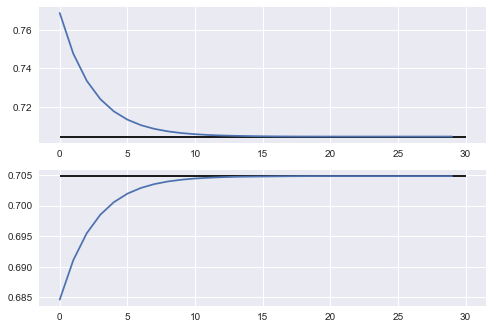

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(kp)
ax[1].plot(h)
ax[0].hlines(kss, 0, T)
ax[1].hlines(hss, 0, T)


#### Example Judd, p. 106

In [22]:
x0 = np.zeros(2)
res = scipy.optimize.minimize(obj, x0, method = 'BFGS', tol = 1e-12)
print(res)

      fun: -0.3731764300060745
 hess_inv: array([[ 953.18473656, -636.48172799],
       [-636.48172799,  425.16859319]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 152
      nit: 18
     njev: 38
   status: 0
  success: True
        x: array([-0.56254632,  1.07694443])
